# For Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
os.chdir("drive/My Drive/Slikovna biometrija/Assigment2")
!ls

In [2]:
os.getcwd()

'D:\\faks\\Slikovna biometrija\\Assigment2'

# Imports

In [1]:
import transforms as T
import numpy as np
import torch
from data.ears.AWEDataset import AWETestSet, AWETrainSet
from detectors.your_super_detector.detector import CNNEarDetector
import cv2
import utils
import os
import matplotlib.pyplot as plt

def get_transform_sharpening():
    transforms = []
    transforms.append(T.ImageSharpening())
    transforms.append(T.ToTensor())
    
    return T.Compose(transforms)

def get_transform():
    transforms = []
    transforms.append(T.ToTensor())
    
    return T.Compose(transforms)

def get_transform_equalization():
    transforms = []
    transforms.append(T.HistogramEqualization())
    transforms.append(T.ToTensor())
    
    return T.Compose(transforms)

def get_transform_edge():
    transforms = []
    transforms.append(T.EdgeEnhancement())
    transforms.append(T.ToTensor())
    
    return T.Compose(transforms)

In [2]:
torch.cuda.is_available()

True

# Test dataset

This block of cells check whether dataset class is written properly

In [8]:
train_data = AWETrainSet(os.path.join(os.getcwd(), "data/ears"), None)
train_data[0]

(<PIL.Image.Image image mode=RGB size=480x360 at 0x1C53DF3ED88>,
 {'boxes': tensor([[165., 217., 187., 278.]]),
  'labels': tensor([1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
  'image_id': tensor([0]),
  'area': tensor([1342.]),
  'iscrowd': tensor([0])})

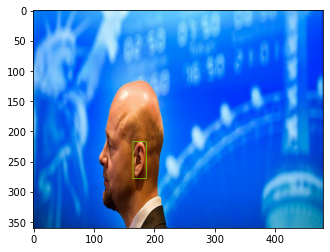

In [9]:
image, target = train_data[0]
plt.imshow(image)
boxes = [box.numpy() for box in target["boxes"]]
image = np.array(image)
for box in boxes:
    cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (128, 255, 0))
plt.imshow(image)

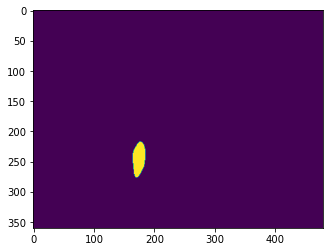

In [11]:
masks = [mask.numpy() for mask in target["masks"]]
plt.imshow(masks[0])

In [12]:
for box in boxes:
    print((box[2]-box[0])*(box[3]-box[1]))

1342.0


# Mask R CNN without preprocessing
## Load data

In [4]:
train_data = AWETrainSet(os.path.join(os.getcwd(), "data/ears"), get_transform())
train_data[0]

## Train and save model

In [5]:
model = CNNEarDetector()
model.set_otpimizer(learning_rate=1e-5, weight_decay=1e-2)
model.train(train_data, num_epochs=5)

In [7]:
model.save(os.getcwd(), "trained_new")

## Some testing

In [8]:
data_loader = torch.utils.data.DataLoader(
 train_data, batch_size=2, shuffle=True, num_workers=4,
 collate_fn=utils.collate_fn)
# For Training
images,targets = next(iter(data_loader))
images = list(image.to(torch.device('cuda')) for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
#output_train = model(images,targets)
model.set_eval()
output_test = model(images)

In [6]:
output_train

{'loss_classifier': tensor(0.1016, grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.1021, grad_fn=<DivBackward0>),
 'loss_mask': tensor(0.3415, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_objectness': tensor(0.0211, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.0039, grad_fn=<DivBackward0>)}

In [ ]:
targets

In [ ]:
output_test

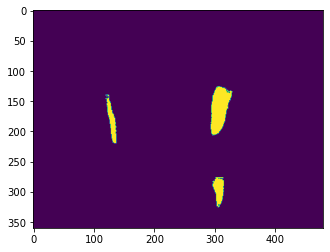

In [10]:
masks = [mask.to(torch.device('cpu')).detach().numpy()[0] for mask in output_test[0]["masks"]]
mask = np.zeros(masks[0].shape)
for m in masks:
    mask = np.logical_or(mask, m > 0.5)
plt.imshow(mask)

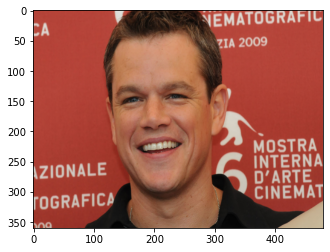

In [11]:
img = cv2.imread(f"data/ears/train/{targets[0]['image_id'].detach().numpy()[0]+1:04d}.png")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

## Load trained model

In [2]:
from detectors.your_super_detector.detector import CNNEarDetector

model = CNNEarDetector()
model.load(os.getcwd(), "trained_new")

## Predictions

In [5]:
import utils

test_data = AWETestSet(os.path.join(os.getcwd(), "data/ears"), get_transform())

test_data_loader = torch.utils.data.DataLoader(
 test_data, batch_size=1, shuffle=False, num_workers=2,
 collate_fn=utils.collate_fn)

In [6]:
model.store_predictions(test_data_loader, os.getcwd(), "predictions_new")

Iteration 0


C:\Users\Domen\anaconda3\envs\Assigment2\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Iteration 10
Iteration 20
Iteration 30
Iteration 40
Iteration 50
Iteration 60
Iteration 70
Iteration 80
Iteration 90
Iteration 100
Iteration 110
Iteration 120
Iteration 130
Iteration 140
Iteration 150
Iteration 160
Iteration 170
Iteration 180
Iteration 190
Iteration 200
Iteration 210
Iteration 220
Iteration 230
Iteration 240


# Mask R CNN with histogram equalization

## Load data

In [2]:
train_data = AWETrainSet(os.path.join(os.getcwd(), "data/ears"), get_transform_equalization())
train_data[0]

## Train and save model

In [4]:
model = CNNEarDetector()
model.set_otpimizer(learning_rate=1e-5, weight_decay=1e-2)
model.train(train_data, num_epochs=5)

Training model on GPUs


C:\Users\Domen\anaconda3\envs\Assigment2\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: [0]  [  0/375]  eta: 1:12:06  lr: 0.000000  loss: 3.8544 (3.8544)  loss_classifier: 0.9370 (0.9370)  loss_box_reg: 0.0732 (0.0732)  loss_mask: 2.7051 (2.7051)  loss_objectness: 0.1366 (0.1366)  loss_rpn_box_reg: 0.0025 (0.0025)  time: 11.5369  data: 4.0911  max mem: 2135
Epoch: [0]  [ 10/375]  eta: 0:12:44  lr: 0.000000  loss: 4.3260 (4.2250)  loss_classifier: 0.8875 (0.8779)  loss_box_reg: 0.0498 (0.0547)  loss_mask: 3.1854 (3.1620)  loss_objectness: 0.1229 (0.1254)  loss_rpn_box_reg: 0.0029 (0.0049)  time: 2.0937  data: 0.3736  max mem: 2303
Epoch: [0]  [ 20/375]  eta: 0:09:19  lr: 0.000001  loss: 4.3976 (4.3142)  loss_classifier: 0.8800 (0.8737)  loss_box_reg: 0.0409 (0.0507)  loss_mask: 3.3869 (3.2663)  loss_objectness: 0.1038 (0.1189)  loss_rpn_box_reg: 0.0029 (0.0047)  time: 1.0777  data: 0.0020  max mem: 2303
Epoch: [0]  [ 30/375]  eta: 0:07:59  lr: 0.000001  loss: 4.1610 (4.1821)  loss_classifier: 0.8234 (0.8457)  loss_box_reg: 0.0220 (0.0429)  loss_mask: 3.1447 (3.1637)

In [5]:
model.save(os.getcwd(), "trained_histogram")

## Quick test

In [6]:
data_loader = torch.utils.data.DataLoader(
 train_data, batch_size=2, shuffle=True, num_workers=4,
 collate_fn=utils.collate_fn)
# For Training
images,targets = next(iter(data_loader))
images = list(image.to(torch.device('cuda')) for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
#output_train = model(images,targets)
model.set_eval()
output_test = model(images)

In [ ]:
output_test

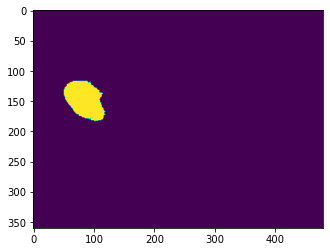

In [8]:
masks = [mask.to(torch.device('cpu')).detach().numpy()[0] for mask in output_test[0]["masks"]]
mask = np.zeros(masks[0].shape)
for m in masks:
    mask = np.logical_or(mask, m > 0.5)
plt.imshow(mask)

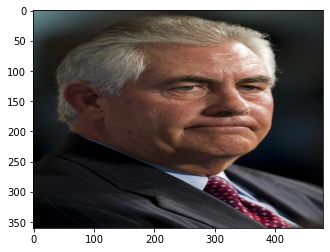

In [9]:
img = cv2.imread(f"data/ears/train/{targets[0]['image_id'].detach().numpy()[0]+1:04d}.png")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

## Load trained model

In [3]:
model = CNNEarDetector()
model.load(os.getcwd(), "trained_histogram")

## Make predictions

In [6]:
test_data = AWETestSet(os.path.join(os.getcwd(), "data/ears"), get_transform_equalization())

test_data_loader = torch.utils.data.DataLoader(
 test_data, batch_size=1, shuffle=False, num_workers=2,
 collate_fn=utils.collate_fn)

model.store_predictions(test_data_loader, os.getcwd(), "predictions_histogram")

Iteration 0
Iteration 10
Iteration 20
Iteration 30
Iteration 40
Iteration 50
Iteration 60
Iteration 70
Iteration 80
Iteration 90
Iteration 100
Iteration 110
Iteration 120
Iteration 130
Iteration 140
Iteration 150
Iteration 160
Iteration 170
Iteration 180
Iteration 190
Iteration 200
Iteration 210
Iteration 220
Iteration 230
Iteration 240


# Mask R CNN with edge enhancement

## Load data

In [4]:
train_data = AWETrainSet(os.path.join(os.getcwd(), "data/ears"), get_transform_edge())

In [6]:
train_data[0]

(tensor([[[0.1961, 0.0863, 0.0471,  ..., 0.0000, 0.0118, 0.0118],
          [0.1490, 0.0353, 0.0706,  ..., 0.0000, 0.0157, 0.0000],
          [0.1059, 0.0549, 0.1176,  ..., 0.0000, 0.0235, 0.0000],
          ...,
          [0.0235, 0.0000, 0.0000,  ..., 0.0745, 0.1412, 0.0000],
          [0.0235, 0.0000, 0.0000,  ..., 0.0118, 0.0784, 0.0000],
          [0.0627, 0.0000, 0.0000,  ..., 0.1059, 0.0588, 0.0000]],
 
         [[0.6549, 0.5059, 0.4784,  ..., 0.4706, 0.3765, 0.0000],
          [0.5843, 0.4706, 0.5176,  ..., 0.4784, 0.3451, 0.0000],
          [0.5529, 0.5020, 0.5725,  ..., 0.4588, 0.3686, 0.0000],
          ...,
          [0.2471, 0.2078, 0.1843,  ..., 0.6118, 0.5333, 0.0863],
          [0.2588, 0.2196, 0.1569,  ..., 0.6000, 0.5098, 0.0392],
          [0.2196, 0.1843, 0.1608,  ..., 0.7333, 0.5255, 0.0941]],
 
         [[1.0000, 0.9608, 0.9176,  ..., 1.0000, 0.9255, 0.3804],
          [0.9922, 0.8941, 0.9647,  ..., 1.0000, 0.9333, 0.3843],
          [0.9255, 0.8902, 1.0000,  ...,

## Train and save model

In [7]:
model = CNNEarDetector()
model.set_otpimizer(learning_rate=1e-5, weight_decay=1e-2)
model.train(train_data, num_epochs=5)

Training model on GPUs


C:\Users\Domen\anaconda3\envs\Assigment2\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: [0]  [  0/375]  eta: 0:46:31  lr: 0.000000  loss: 2.4849 (2.4849)  loss_classifier: 0.6657 (0.6657)  loss_box_reg: 0.0479 (0.0479)  loss_mask: 1.6454 (1.6454)  loss_objectness: 0.1192 (0.1192)  loss_rpn_box_reg: 0.0067 (0.0067)  time: 7.4449  data: 3.8829  max mem: 2135
Epoch: [0]  [ 10/375]  eta: 0:09:46  lr: 0.000000  loss: 2.4604 (2.4840)  loss_classifier: 0.6909 (0.7162)  loss_box_reg: 0.0663 (0.0627)  loss_mask: 1.5303 (1.6024)  loss_objectness: 0.0735 (0.0964)  loss_rpn_box_reg: 0.0042 (0.0063)  time: 1.6064  data: 0.3549  max mem: 2302
Epoch: [0]  [ 20/375]  eta: 0:07:40  lr: 0.000001  loss: 2.4784 (2.7246)  loss_classifier: 0.6909 (0.7027)  loss_box_reg: 0.0629 (0.0685)  loss_mask: 1.6441 (1.8547)  loss_objectness: 0.0735 (0.0937)  loss_rpn_box_reg: 0.0035 (0.0049)  time: 0.9908  data: 0.0020  max mem: 2302
Epoch: [0]  [ 30/375]  eta: 0:06:51  lr: 0.000001  loss: 2.3465 (2.5610)  loss_classifier: 0.6563 (0.6784)  loss_box_reg: 0.0767 (0.0776)  loss_mask: 1.5610 (1.7206) 

In [8]:
model.save(os.getcwd(), "trained_edge")

## Quick test

In [9]:
data_loader = torch.utils.data.DataLoader(
 train_data, batch_size=2, shuffle=True, num_workers=4,
 collate_fn=utils.collate_fn)
# For Training
images,targets = next(iter(data_loader))
images = list(image.to(torch.device('cuda')) for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
#output_train = model(images,targets)
model.set_eval()
output_test = model(images)

In [10]:
output_test

[{'boxes': tensor([[ 81.5261, 159.4291, 125.7425, 239.5376],
          [115.7767, 230.5537, 142.7927, 276.3199],
          [ 72.3533, 218.2516, 131.9377, 268.6002],
          [ 72.1485, 101.4778, 128.8090, 258.5724],
          [ 90.2222, 159.6877, 114.4549, 225.7722]], device='cuda:0',
         grad_fn=<StackBackward0>),
  'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'),
  'scores': tensor([0.4549, 0.1974, 0.1756, 0.0978, 0.0697], device='cuda:0',
         grad_fn=<IndexBackward0>),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0

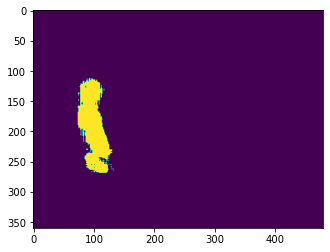

In [11]:
masks = [mask.to(torch.device('cpu')).detach().numpy()[0] for mask in output_test[0]["masks"]]
mask = np.zeros(masks[0].shape)
for m in masks:
    mask = np.logical_or(mask, m > 0.5)
plt.imshow(mask)

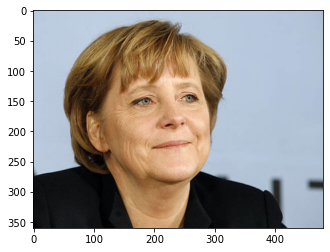

In [12]:
img = cv2.imread(f"data/ears/train/{targets[0]['image_id'].detach().numpy()[0]+1:04d}.png")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

## Load trained model

In [2]:
model = CNNEarDetector()
model.load(os.getcwd(), "trained_edge")

## Make predictions

In [5]:
test_data = AWETestSet(os.path.join(os.getcwd(), "data/ears"), get_transform_edge())

test_data_loader = torch.utils.data.DataLoader(
 test_data, batch_size=1, shuffle=False, num_workers=2,
 collate_fn=utils.collate_fn)

model.store_predictions(test_data_loader, os.getcwd(), "predictions_edge")

Iteration 0


C:\Users\Domen\anaconda3\envs\Assigment2\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Iteration 10
Iteration 20
Iteration 30
Iteration 40
Iteration 50
Iteration 60
Iteration 70
Iteration 80
Iteration 90
Iteration 100
Iteration 110
Iteration 120
Iteration 130
Iteration 140
Iteration 150
Iteration 160
Iteration 170
Iteration 180
Iteration 190
Iteration 200
Iteration 210
Iteration 220
Iteration 230
Iteration 240


# Mask R CNN with image sharpening

## Load data

In [4]:
train_data = AWETrainSet(os.path.join(os.getcwd(), "data/ears"), get_transform_sharpening())

In [4]:
train_data[0]

(tensor([[[0.0902, 0.0706, 0.0588,  ..., 0.0039, 0.0039, 0.0039],
          [0.0784, 0.0588, 0.0588,  ..., 0.0039, 0.0039, 1.0000],
          [0.0588, 0.0510, 0.0627,  ..., 1.0000, 0.0039, 1.0000],
          ...,
          [0.0039, 0.0000, 0.0000,  ..., 0.0549, 0.0510, 0.9922],
          [0.0039, 0.0000, 0.0000,  ..., 0.0392, 0.0392, 0.9843],
          [0.0118, 0.0000, 0.0000,  ..., 0.0588, 0.0314, 0.9961]],
 
         [[0.5373, 0.5098, 0.4980,  ..., 0.3804, 0.3020, 0.1569],
          [0.5255, 0.5020, 0.5059,  ..., 0.3804, 0.2941, 0.1490],
          [0.5137, 0.5059, 0.5176,  ..., 0.3765, 0.2980, 0.1451],
          ...,
          [0.2039, 0.1922, 0.1804,  ..., 0.5176, 0.4745, 0.3804],
          [0.2039, 0.1961, 0.1725,  ..., 0.5137, 0.4667, 0.3647],
          [0.2000, 0.1882, 0.1725,  ..., 0.5373, 0.4706, 0.3765]],
 
         [[0.9608, 0.9451, 0.9333,  ..., 0.9882, 0.8941, 0.7686],
          [0.9451, 0.9294, 0.9451,  ..., 0.9882, 0.8941, 0.7686],
          [0.9255, 0.9255, 0.9529,  ...,

## Train and save model

In [5]:
model = CNNEarDetector()
model.set_otpimizer(learning_rate=1e-5, weight_decay=1e-2)
model.train(train_data, num_epochs=5)

Training model on GPUs


C:\Users\Domen\anaconda3\envs\Assigment2\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: [0]  [  0/375]  eta: 0:49:20  lr: 0.000000  loss: 4.8520 (4.8520)  loss_classifier: 0.6983 (0.6983)  loss_box_reg: 0.0984 (0.0984)  loss_mask: 4.0298 (4.0298)  loss_objectness: 0.0245 (0.0245)  loss_rpn_box_reg: 0.0009 (0.0009)  time: 7.8948  data: 3.9646  max mem: 2135
Epoch: [0]  [ 10/375]  eta: 0:10:18  lr: 0.000000  loss: 4.8520 (4.8697)  loss_classifier: 0.6832 (0.6828)  loss_box_reg: 0.0622 (0.0604)  loss_mask: 4.0298 (4.0378)  loss_objectness: 0.0866 (0.0843)  loss_rpn_box_reg: 0.0049 (0.0045)  time: 1.6943  data: 0.3624  max mem: 2305
Epoch: [0]  [ 20/375]  eta: 0:08:06  lr: 0.000001  loss: 4.7941 (4.8634)  loss_classifier: 0.6812 (0.6784)  loss_box_reg: 0.0588 (0.0548)  loss_mask: 3.8989 (4.0340)  loss_objectness: 0.1020 (0.0914)  loss_rpn_box_reg: 0.0047 (0.0048)  time: 1.0434  data: 0.0020  max mem: 2305
Epoch: [0]  [ 30/375]  eta: 0:07:13  lr: 0.000001  loss: 4.4535 (4.5401)  loss_classifier: 0.6423 (0.6583)  loss_box_reg: 0.0530 (0.0543)  loss_mask: 3.5986 (3.7305) 

In [6]:
model.save(os.getcwd(), "trained_sharpening")

## Quick test

In [7]:
data_loader = torch.utils.data.DataLoader(
 train_data, batch_size=2, shuffle=True, num_workers=4,
 collate_fn=utils.collate_fn)
# For Training
images,targets = next(iter(data_loader))
images = list(image.to(torch.device('cuda')) for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
#output_train = model(images,targets)
model.set_eval()
output_test = model(images)

In [8]:
output_test

[{'boxes': tensor([[327.3279,  46.7564, 349.8279, 110.2964],
          [ 35.1855, 135.4106,  92.3436, 241.4405],
          [326.0661,  50.2614, 347.8907,  84.1613],
          [161.3298,  83.8402, 238.4735, 162.8793],
          [290.2560, 148.2914, 306.8807, 174.9942],
          [ 73.1303, 181.1537,  88.5923, 223.1275],
          [ 36.7914, 141.8017,  81.5797, 203.1496],
          [ 59.2664, 175.9126, 105.2228, 265.4015],
          [ 70.7508, 216.9059, 102.8148, 264.4327],
          [311.0119,  50.5621, 353.5100, 102.6825]], device='cuda:0',
         grad_fn=<StackBackward0>),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'),
  'scores': tensor([0.9068, 0.4671, 0.1353, 0.1290, 0.0927, 0.0924, 0.0911, 0.0890, 0.0644,
          0.0532], device='cuda:0', grad_fn=<IndexBackward0>),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 

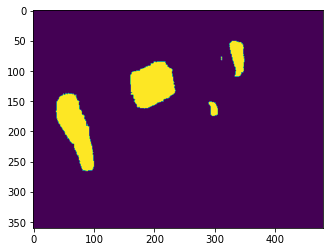

In [9]:
masks = [mask.to(torch.device('cpu')).detach().numpy()[0] for mask in output_test[0]["masks"]]
mask = np.zeros(masks[0].shape)
for m in masks:
    mask = np.logical_or(mask, m > 0.5)
plt.imshow(mask)

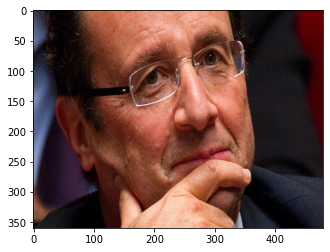

In [10]:
img = cv2.imread(f"data/ears/train/{targets[0]['image_id'].detach().numpy()[0]+1:04d}.png")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

## Load trained model

In [2]:
model = CNNEarDetector()
model.load(os.getcwd(), "trained_sharpening")

## Make predictions

In [5]:
test_data = AWETestSet(os.path.join(os.getcwd(), "data/ears"), get_transform_sharpening())

test_data_loader = torch.utils.data.DataLoader(
 test_data, batch_size=1, shuffle=False, num_workers=2,
 collate_fn=utils.collate_fn)

model.store_predictions(test_data_loader, os.getcwd(), "predictions_sharpening")

Iteration 0


C:\Users\Domen\anaconda3\envs\Assigment2\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Iteration 10
Iteration 20
Iteration 30
Iteration 40
Iteration 50
Iteration 60
Iteration 70
Iteration 80
Iteration 90
Iteration 100
Iteration 110
Iteration 120
Iteration 130
Iteration 140
Iteration 150
Iteration 160
Iteration 170
Iteration 180
Iteration 190
Iteration 200
Iteration 210
Iteration 220
Iteration 230
Iteration 240


# Retrain the best model on more epochs

In [3]:
train_data = AWETrainSet(os.path.join(os.getcwd(), "data/ears"), get_transform_equalization())
train_data[0]

(tensor([[[0.2784, 0.2627, 0.2510,  ..., 0.0510, 0.0000, 0.0000],
          [0.2706, 0.2510, 0.2510,  ..., 0.0510, 0.0000, 0.0000],
          [0.2471, 0.2392, 0.2510,  ..., 0.0392, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.2039, 0.1529, 0.0235],
          [0.0000, 0.0000, 0.0000,  ..., 0.1882, 0.1373, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.2078, 0.1333, 0.0078]],
 
         [[0.7294, 0.7137, 0.6980,  ..., 0.4157, 0.2157, 0.0392],
          [0.7216, 0.7020, 0.6980,  ..., 0.4157, 0.1961, 0.0353],
          [0.7020, 0.6941, 0.7098,  ..., 0.4039, 0.1961, 0.0275],
          ...,
          [0.0471, 0.0431, 0.0392,  ..., 0.6627, 0.5765, 0.4353],
          [0.0471, 0.0471, 0.0353,  ..., 0.6549, 0.5725, 0.4039],
          [0.0431, 0.0392, 0.0353,  ..., 0.6745, 0.5765, 0.4196]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.8118, 0.6471],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.8039, 0.6431],
          [1.0000, 1.0000, 1.0000,  ...,

In [4]:
model = CNNEarDetector()
model.set_otpimizer(learning_rate=1e-5, weight_decay=1e-2)
model.train(train_data, num_epochs=20)

Training model on GPUs


C:\Users\Domen\anaconda3\envs\Assigment2\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: [0]  [  0/375]  eta: 1:02:42  lr: 0.000000  loss: 2.2700 (2.2700)  loss_classifier: 0.9086 (0.9086)  loss_box_reg: 0.1188 (0.1188)  loss_mask: 0.8899 (0.8899)  loss_objectness: 0.3389 (0.3389)  loss_rpn_box_reg: 0.0138 (0.0138)  time: 10.0337  data: 4.1597  max mem: 2135
Epoch: [0]  [ 10/375]  eta: 0:11:35  lr: 0.000000  loss: 3.4850 (2.8110)  loss_classifier: 0.9580 (0.9441)  loss_box_reg: 0.0383 (0.0519)  loss_mask: 2.3377 (1.6398)  loss_objectness: 0.1230 (0.1681)  loss_rpn_box_reg: 0.0045 (0.0071)  time: 1.9051  data: 0.3792  max mem: 2303
Epoch: [0]  [ 20/375]  eta: 0:08:41  lr: 0.000001  loss: 3.5082 (24.6732)  loss_classifier: 0.9134 (0.8973)  loss_box_reg: 0.0383 (0.0503)  loss_mask: 2.4615 (23.5497)  loss_objectness: 0.1051 (0.1694)  loss_rpn_box_reg: 0.0038 (0.0064)  time: 1.0396  data: 0.0021  max mem: 2303
Epoch: [0]  [ 30/375]  eta: 0:07:32  lr: 0.000001  loss: 3.6869 (17.9668)  loss_classifier: 0.8385 (0.8778)  loss_box_reg: 0.0355 (0.0476)  loss_mask: 2.5808 (16.8

In [5]:
model.save(os.getcwd(), "trained_best")

## Quick test

In [6]:
data_loader = torch.utils.data.DataLoader(
 train_data, batch_size=2, shuffle=True, num_workers=4,
 collate_fn=utils.collate_fn)
# For Training
images,targets = next(iter(data_loader))
images = list(image.to(torch.device('cuda')) for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
#output_train = model(images,targets)
model.set_eval()
output_test = model(images)

In [7]:
output_test

[{'boxes': tensor([[138.2669,  91.4511, 168.1782, 144.2410],
          [148.4816, 101.2457, 165.7059, 142.1294],
          [137.7623,  88.4039, 163.7378, 123.8259],
          [141.1933, 111.6517, 165.7665, 136.2492],
          [139.0442,  93.3406, 155.8949, 134.5345],
          [448.5743,  81.7959, 480.0000, 213.5002],
          [411.6346, 250.4003, 431.6550, 282.7756],
          [145.5362, 120.8630, 169.0152, 143.9380]], device='cuda:0',
         grad_fn=<StackBackward0>),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'),
  'scores': tensor([0.9671, 0.1951, 0.1796, 0.1143, 0.0708, 0.0559, 0.0554, 0.0516],
         device='cuda:0', grad_fn=<IndexBackward0>),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0

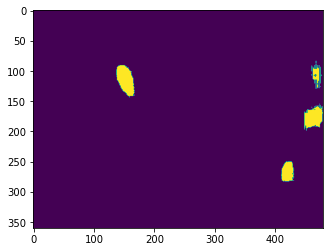

In [8]:
masks = [mask.to(torch.device('cpu')).detach().numpy()[0] for mask in output_test[0]["masks"]]
mask = np.zeros(masks[0].shape)
for m in masks:
    mask = np.logical_or(mask, m > 0.5)
plt.imshow(mask)

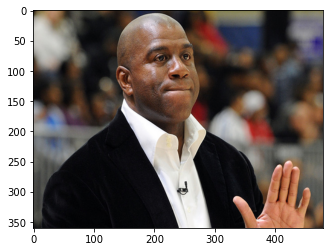

In [9]:
img = cv2.imread(f"data/ears/train/{targets[0]['image_id'].detach().numpy()[0]+1:04d}.png")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

## Load trained model

In [2]:
model = CNNEarDetector()
model.load(os.getcwd(), "trained_best")

## Make predictions

In [3]:
test_data = AWETestSet(os.path.join(os.getcwd(), "data/ears"), get_transform_equalization())

test_data_loader = torch.utils.data.DataLoader(
 test_data, batch_size=1, shuffle=False, num_workers=2,
 collate_fn=utils.collate_fn)

model.store_predictions(test_data_loader, os.getcwd(), "predictions_best")

Iteration 0


C:\Users\Domen\anaconda3\envs\Assigment2\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Iteration 10
Iteration 20
Iteration 30
Iteration 40
Iteration 50
Iteration 60
Iteration 70
Iteration 80
Iteration 90
Iteration 100
Iteration 110
Iteration 120
Iteration 130
Iteration 140
Iteration 150
Iteration 160
Iteration 170
Iteration 180
Iteration 190
Iteration 200
Iteration 210
Iteration 220
Iteration 230
Iteration 240
